## 准备工作

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [ ]:
!pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

## 1. 生成 Embedding (基于 text-embedding-ada-002 模型)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](images/embedding-vectors.svg)

### 亚马逊美食评论数据集(amazon-fine-food-reviews)

Source:[美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)

![dataset](images/amazon-fine-food-reviews.png)


该数据集包含截至2012年10月用户在亚马逊上留下的共计568,454条美食评论。为了说明目的，我们将使用该数据集的一个子集，其中包括最近1,000条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [1]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken

#### 加载数据集

In [2]:
input_datapath = "data/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [3]:
df["combined"]

0      Title: where does one  start...and stop... wit...
1      Title: Arrived in pieces; Content: Not pleased...
2      Title: It isn't blanc mange, but isn't bad . ....
3      Title: These also have SALT and it's not sea s...
4      Title: Happy with the product; Content: My dog...
                             ...                        
995    Title: Delicious!; Content: I have ordered the...
996    Title: Good Training Treat; Content: My dog wi...
997    Title: Jamica Me Crazy Coffee; Content: Wolfga...
998    Title: Party Peanuts; Content: Great product f...
999    Title: I love Maui Coffee!; Content: My first ...
Name: combined, Length: 1000, dtype: object

#### Embedding 模型关键参数

In [4]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
# embedding_model = "text-embedding-ada-002"
embedding_model = "text-embedding-3-small"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [5]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论。
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.sort_values("Time").tail(top_n * 2) 
# 丢弃"Time"列，因为我们在这个分析中不再需要它。
df.drop("Time", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（1000）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)
# df = df[df.n_tokens <= max_tokens]

# 打印出剩余评论的数量。
len(df)

1000

In [6]:
df

,ProductId,UserId,Score,Summary,Text,combined,n_tokens
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178
296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78
295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111
294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78
...,...,...,...,...,...,...,...
623,B0000CFXYA,A3GS4GWPIBV0NT,1,Strange inflammation response,Truthfully wasn't crazy about the taste of the...,Title: Strange inflammation response; Content:...,110
624,B0001BH5YM,A1BZ3HMAKK0NC,5,My favorite and only MUSTARD,You've just got to experience this mustard... ...,Title: My favorite and only MUSTARD; Content:...,80
625,B0009ET7TC,A2FSDQY5AI6TNX,5,My furbabies LOVE these!,Shake the container and they come running. Eve...,Title: My furbabies LOVE these!; Content: Shak...,47
619,B007PA32L2,A15FF2P7RPKH6G,5,got this for the daughter,all i have heard since she got a kuerig is why...,Title: got this for the daughter; Content: all...,50


In [7]:
# len(df["embedding"][0])

#### 生成 Embeddings 并保存


In [8]:
from openai import OpenAI
import httpx

In [9]:
http_client = httpx.Client()
# OpenAI Python SDK v1.0 更新后的使用方式
client = OpenAI(http_client=http_client)

In [18]:
# 新版本创建 Embedding 向量的方法
# Ref：https://community.openai.com/t/embeddings-api-documentation-needs-to-updated/475663
res = client.embeddings.create(input="abc", model=embedding_model)
print(res.data[0].embedding)

[0.03859567269682884, 0.012550137005746365, 0.045168861746788025, 0.021304694935679436, -0.0054534198716282845, 0.019530514255166054, 0.00457723718136549, 0.018265321850776672, -0.02510027401149273, -0.006765876431018114, 0.007525719702243805, -0.029535723850131035, -0.04004991799592972, 0.019937703385949135, 0.07102534174919128, 0.06782600283622742, -0.029608435928821564, 0.017814505845308304, -0.02859046310186386, 0.037025086581707, 0.007976535707712173, 0.019966788589954376, -0.010805043391883373, 0.011975710280239582, -0.007453007623553276, -0.03970089927315712, -0.03458195552229881, -0.013022767379879951, 0.010586906224489212, -0.032865945249795914, 0.04813552275300026, -0.03775221109390259, 0.014447927474975586, 0.00943078100681305, -0.02242446318268776, 0.014549724757671356, -0.013379056937992573, -0.010048835538327694, 0.027005335316061974, -0.03141169995069504, 0.008856354281306267, 0.002495848573744297, 0.02447494864463806, -0.06666260957717896, 0.006536833010613918, 0.021900

In [10]:
# 使用新方法调用 OpenAI Embedding API
def embedding_text(text, model="text-embedding-ada-002"):
    res = client.embeddings.create(input=text, model=model)
    return res.data[0].embedding


### 注意：如果未使用信用卡支付过 OpenAI 账单的同学，可以直接跳过此步骤。

### 提醒：非必须步骤，可直接复用项目中的嵌入文件 fine_food_reviews_with_embeddings_1k

对于免费试用用户的前48小时，OpenAI 设置了 [速率限制](https://platform.openai.com/docs/guides/rate-limits/overview)

如果你已经支付过 OpenAI API 账单，可以尝试取消注释，调用以下代码测试批量 Embedding：

In [20]:
# 实际生成会耗时几分钟，逐行调用 OpenAI Embedding API

# df["embedding"] = df.combined.apply(embedding_text)
# output_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv"
# df.to_csv(output_datapath)

In [11]:
e0 = df["embedding"][0]

KeyError: 'embedding'

In [12]:
e0

NameError: name 'e0' is not defined

## 2.读取 fine_food_reviews_with_embeddings_1k 嵌入文件

In [14]:
# embedding_datapath = "data/fine_food_reviews_with_embeddings_1k.csv"
embedding_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv"

df_embedded = pd.read_csv(embedding_datapath, index_col=0)

#### 查看 Embedding 结果

In [15]:
df_embedded["embedding"]

0      [0.007003408391028643, -0.027408825233578682, ...
297    [-0.003353930078446865, -0.009971054270863533,...
296    [-0.017364047467708588, -6.116097210906446e-05...
295    [-0.0014289027312770486, -0.011193621903657913...
294    [-0.017364047467708588, -6.116097210906446e-05...
                             ...                        
623    [0.00011952989734709263, -0.004721797071397304...
624    [-0.020833710208535194, -0.013156373985111713,...
625    [-0.009701178409159184, -0.006883217021822929,...
619    [-0.005275089759379625, 0.0009050238877534866,...
999    [-0.006082124542444944, -0.015024509280920029,...
Name: embedding, Length: 1000, dtype: object

In [16]:
len(df_embedded["embedding"][0])

34417

In [17]:
type(df_embedded["embedding"][0])

str

In [18]:
df_embedded["embedding"][0]

'[0.007003408391028643, -0.027408825233578682, 0.01052916795015335, -0.014611626043915749, 0.004470772575587034, 0.02001366578042507, 0.0006816983222961426, -0.02203427627682686, -0.01931263878941536, -0.013532591983675957, 0.018116766586899757, 0.003924382850527763, -0.03298955783247948, 0.0001599005627213046, 0.01588997058570385, 0.019408857449889183, 0.017759378999471664, -0.02626793645322323, -0.01951882243156433, -0.025072066113352776, -0.04747747629880905, -0.00726457592099905, 0.0237524826079607, -0.008659759536385536, -0.009030891582369804, 0.011388271115720272, 0.02960813045501709, -0.0224741380661726, -0.01026800088584423, 0.02166314423084259, 0.0011924351565539837, 0.009065256454050541, -0.013360771350562572, -0.017360756173729897, -0.005835028365254402, -0.010865936055779457, -0.02647412195801735, 0.007360795512795448, 0.0225291196256876, -0.020274832844734192, 0.01907896250486374, -0.015491347759962082, 0.009298931807279587, -0.008254262618720531, 0.0018367624143138528, 0.

In [19]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [20]:
len(df_embedded["embedding_vec"][0])

1536

In [21]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007003408391028643, -0.027408825233578682, ...","[0.007003408391028643, -0.027408825233578682, ..."
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.003353930078446865, -0.009971054270863533,...","[-0.003353930078446865, -0.009971054270863533,..."


## 3. 使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [22]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [23]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [24]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [25]:
df_embedded["embedding_vec"].values

In [23]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [24]:
matrix

array([[ 7.00340839e-03, -2.74088252e-02,  1.05291680e-02, ...,
        -7.14086508e-03, -2.19518021e-02, -3.76080982e-02],
       [-3.35393008e-03, -9.97105427e-03, -3.75151844e-03, ...,
        -9.77968425e-03, -2.34593637e-03, -9.32435412e-03],
       [-1.73640475e-02, -6.11609721e-05, -1.16387494e-02, ...,
        -1.38159757e-02, -3.90825458e-02, -2.36000512e-02],
       ...,
       [-9.70117841e-03, -6.88321702e-03, -5.83720580e-03, ...,
        -3.00934520e-02, -8.08431488e-03, -1.93495620e-02],
       [-5.27508976e-03,  9.05023888e-04,  2.82295644e-02, ...,
        -5.45462547e-03, -1.34096956e-02, -2.72111073e-02],
       [-6.08212454e-03, -1.50245093e-02, -2.14356626e-03, ...,
        -2.91368626e-02, -1.41253844e-02, -2.28429884e-02]])

In [25]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [26]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [27]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [28]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

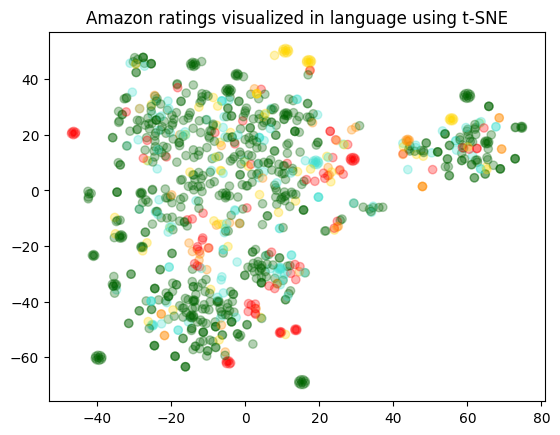

In [29]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，评论大致分为3个大类。**

## 4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [30]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

In [31]:
df_embedded['Cluster']

0      3
297    2
296    3
295    0
294    3
      ..
623    2
624    0
625    1
619    2
999    2
Name: Cluster, Length: 1000, dtype: int32

In [32]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007003408391028643, -0.027408825233578682, ...","[0.007003408391028643, -0.027408825233578682, ...",3
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.003353930078446865, -0.009971054270863533,...","[-0.003353930078446865, -0.009971054270863533,...",2


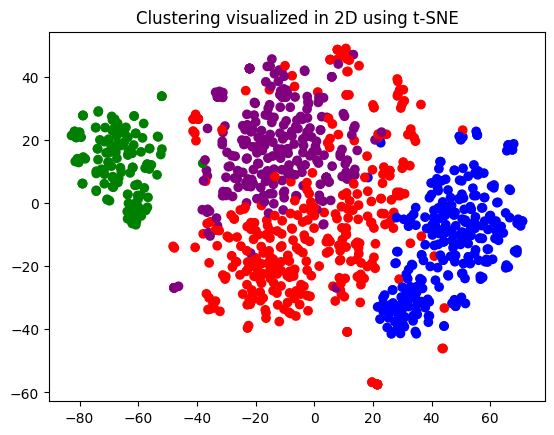

In [33]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类（官方介绍：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论）。**

## 5. 使用 Embedding 进行文本搜索

![cosine](images/cosine.png)

In [34]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [35]:
type(df_embedded["embedding_vec"][0])

list

In [36]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = embedding_text(product_description)
    
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:500])
            print()
    return results

In [37]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, 'delicious beans', n=3)

NameError: name 'embedding_text' is not defined

In [56]:
res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google for them.

chow time:  a fine delicacy, with a pleasant smell and taste  that my dogs look forward to. Packaging is easy to store and dispose



In [60]:
res = search_reviews(df_embedded, '狗粮', n=3)

chow time:  a fine delicacy, with a pleasant smell and taste  that my dogs look forward to. Packaging is easy to store and dispose

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo



In [57]:
res = search_reviews(df_embedded, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  One taste caused me to throw out my sandwich, and subsequently throw out the entire jar of unused mayonnaise.<br /><br />I would give this less than 1 star, if I could.<br /><br />Steer clear from this unless you're a major tool who has no sensibility past buying bacon-everything.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate and not this swill.  I had one pod in a sample pack so at least I didn't buy a whole box of them.

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Arrived in pieces:  Not pleased at 

In [40]:
res = search_reviews(df_embedded, '电器', n=5)

NameError: name 'client' is not defined

In [59]:
res = search_reviews(df_embedded, 'late delivery', n=5)

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa

not enough:  i love the cereal, but there is too much time elapsed between shipments.  since i have a bowl every morning, i run out quickly.  i wouldn't mind shipments coming twice as fast.



In [58]:
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = embedding_text(product_description)

    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

chow time:  a fine delicacy, with a pleasant smell and taste  that my dogs look forward to. Packaging is easy to store and dispose

